# Quickstart
In this tutorial we will setup a quick and simple simulation that gives us the occasion to show the basic features of cascade. For basic astrodynamics 
computations we make use of [pykep](https://esa.github.io/pykep/). We are going to simulate a random population of 1,000 objects orbiting around the Earth in a purely Keplerian fashion and we will monitor their collisions and conjunctions.

Let us start with some imports:

In [1]:
# core imports
import cascade as csc
import pykep as pk
import numpy as np
import heyoka as hy

# plotting
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
%matplotlib inline

## The dynamics

For this tutorial we will make use a simple non dimensional Keplerian dynamics and make use of the {mod}`cascade.dynamics` module to instantiate it.

```{note} 
A dynamics is defined by tuples of [heyoka](https://bluescarni.github.io/heyoka.py/) expressions containing the state variable and the corresponding expression for its derivative. 
```

Let us instantiate a simple Keplerian dynamics and inspect it:

In [2]:
dyn = csc.dynamics.kepler(mu = 1)
dyn

[(x, vx),
 (y, vy),
 (z, vz),
 (vx, (-x * pow((x**2 + y**2 + z**2), -1.5000000000000000))),
 (vy, (-y * pow((x**2 + y**2 + z**2), -1.5000000000000000))),
 (vz, (-z * pow((x**2 + y**2 + z**2), -1.5000000000000000)))]

## The initial conditions

To fully define the system initial conditions we need to define the starting values for the position and velocity of all orbiting objects as well as their dimension (see {class}`cascade.sim`), which will be used to define collisions. We here make sure to define rather large particles as to allow collisions show up already early on.


In [3]:
N = 1000 # number of objects simulated
# The following numpy array will hold all the initial conditions and object radius [x,y,z,vx,vy,vz,r]
ic_state = np.zeros((N, 7))
# We generate randomly orbital parameters and imensions and transform them to Cartesian state. Note we make use of nondimensional units as defined in the dynamics.
for i in range(N):
    a = np.random.uniform(1.02, 1.3)
    e = np.random.uniform(0, 0.02)
    inc = np.random.uniform(np.pi/3, np.pi/3 + 0.05)
    om = np.random.uniform(0, 2*np.pi)
    Om = np.random.uniform(np.pi/3, np.pi/3 + 0.05)
    nu = np.random.uniform(0, 2*np.pi)
    size = np.random.uniform(1e-3/2, 1e-4)
    r, v = pk.par2ic([a, e, inc, Om, om, nu], mu = 1.)
    ic_state[i][:3] = r
    ic_state[i][3:6] = v
    ic_state[i][6] = size

... and we visualize them in proportion to a central body with radius 0.5

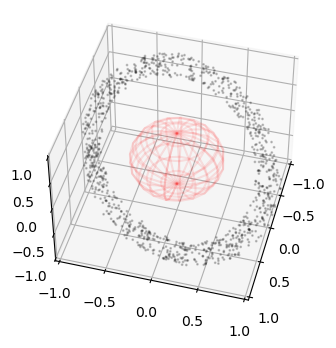

In [4]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

r = 0.5
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = r*np.cos(u)*np.sin(v)
y = r*np.sin(u)*np.sin(v)
z = r*np.cos(v)
ax.plot_wireframe(x, y, z, color="r", alpha=0.1)

ax.scatter3D(ic_state[:,0], ic_state[:,1], ic_state[:,2], alpha=0.2, s= 1, c='k')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

ax.view_init(45,15)

## Building the simulation

cascade main interface is offered via {class}`cascade.sim`, essentially, a container for the dynamics of n-bodies that interact only via collisions and possible conjunctions. By default a cascade simulation will only track collisions between all the objects. To activate conjunction tracking, minimal collision radii, object whitelists or reentry / exit events, specific arguments need to be defined and are the subject of more advanced tutorials.

In [5]:
sim = csc.sim(state = ic_state, dyn=dyn, ct = 2*np.pi / 90)

The ``state`` kwarg initializes the initial conditions for the simulation. The ``dyn`` kwarg specifies the dynamics and the ``ct`` kwarg, called collisional timestep, a time interval that represents how frequently cascade resolves collisions and conjunctions between particles.

```{tip} 
The value chosen for the collisional timestep does not modify the results of the simulation, only its efficiency! Its value should be small enough to allow a good amount of collisions to be excluded on the basis of the preliminary broad-phase of the cascade algorithm. Choosing an exeedingly small value, on the other hand, will result in a slow runtime as too many collision checks are performed.
 ```

## Running the simulation up to the first collision

In [6]:
# This will try to propagate all the orbits up to a collision event is triggered or the final time is reached
oc = sim.propagate_until(30 * np.pi)


```{note}
We have setup things so that a collision is almost certainly happening early on .... if thats the case the simulation {class}`~cascade.outcome` will be ``collision`` and the information contained in the {attr}`~cascade.sim.interrupt_info` attribute will be identify the objects involved.
```

In [7]:
time = sim.time
pi, pj = sim.interrupt_info
print("Outcome: ", oc.name)
print("Time: ", sim.time)
print("Particle", pi, "collided with particle", pj)

Outcome:  collision
Time:  4.241685177599553
Particle 649 collided with particle 796


At this point one can react to the collision adding fragments, removing particles, ignoring the collision etc.. to then start again the simulation. We here stop and 
visualize the position of the collision.

## Plotting the collision position

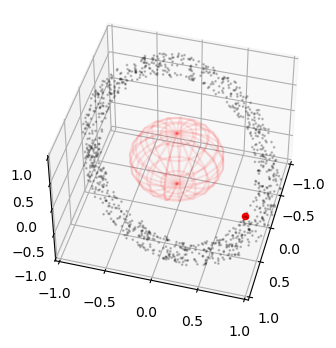

In [8]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111, projection='3d')

r = 0.5
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = r*np.cos(u)*np.sin(v)
y = r*np.sin(u)*np.sin(v)
z = r*np.cos(v)
ax.plot_wireframe(x, y, z, color="r", alpha=0.1)

ax.scatter3D(ic_state[:,0], ic_state[:,1], ic_state[:,2], alpha=0.2, s= 1, c='k')
ax.scatter3D(sim.state[pi,0], sim.state[pi,1], sim.state[pi,2], alpha=1, s= 20, c='r')

ax.set_xlim(-1,1)
ax.set_ylim(-1,1)
ax.set_zlim(-1,1)

ax.view_init(45,15)